In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




# Volatility timing


  * Using daily data for month t, construct the market return "realized variance" during month t
   
   $$rv_t=\sum_{d \in days~ in ~month ~t}\frac{(r_d- \overline{r})^2}{N_{days}},$$
   
 where $\overline{R}$ is the average return within the month
   
  * Buy the market at the closing price of month t accoding to the rule:
   
   $$W_t=\frac{c}{rv_t},$$
   
where $c$ is some constant.
   
  * Hold the postions for a month
  
  * The returns of the strategy are given by
  
  
  $$ r^{VolTiming}_{t+1}=r_{f,t+1}+\frac{c}{rv_t}(r^{MKT}_{t+1}-r_{f,t+1})$$
 
  $$ r^{VolTiming}_{t+1}=(1-\frac{c}{rv_t})r_{f,t+1}+\frac{c}{rv_t}r^{MKT}_{t+1}$$
* One couls use a variety of other volatiltiy estimators to implement the strategy

   - Use Squared returns instead of variance
   - VIX
   - GARCH based forecasts
   - Regression forecasts based lagged rv
   - Regression forecasts based lagged rv and VIX
   
* For this implementation which was developed in a [paper of mine with Tyler Muir](https://www.google.com/url?q=https%3A%2F%2Fwww.dropbox.com%2Fs%2F022escr52x9oe51%2FVolPortfolios_published.pdf%3Fdl%3D0&sa=D&sntz=1&usg=AFQjCNGMECt2zp77lDfZRGJlkXQbGmqn1A) we simply need daily data to construct the realized variance variable

**Download data from WRDS**

(if you have credentials)

In [5]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *


# connect with their server
#conn=wrds.Connection()

# get the value-weighted market returns and date from the data base crsp.dsi
mkt_d = conn.raw_sql("""
                      select a.date, a.vwretd
                      from crsp.dsi as a
                      """) 
# get the risk-free rate
rf_d = conn.raw_sql("""
                      select a.date, a.rf
                      from ff.factors_daily as a
                      """)

mkt_d=mkt_d.set_index(['date'])

mkt_d=mkt_d.set_index(pd.to_datetime(mkt_d.index),'date')

rf_d=rf_d.set_index(['date'])

rf_d=rf_d.set_index(pd.to_datetime(rf_d.index),'date')

# we merge

daily=mkt_d.merge(rf_d,how='left',left_index=True,right_index=True)
# save data locally
#daily.to_pickle('../../assets/data/daily.pkl')


Alternatively simply import from Gihub by substituting the address below

In [6]:

daily=pd.read_pickle('https://github.com/amoreira2/Lectures/blob/main/assets/data/daily.pkl?raw=true')


**Constructing monthly realized variance from daily data**


You basically use pandas time series function that shifts all dates to the end of the month, so this way you are technically grouping by the end of the month day.

In [8]:
daily.index

DatetimeIndex(['1925-12-31', '1926-01-02', '1926-01-04', '1926-01-05',
               '1926-01-06', '1926-01-07', '1926-01-08', '1926-01-09',
               '1926-01-11', '1926-01-12',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=25046, freq=None)

In [14]:
from pandas.tseries.offsets import MonthEnd
endofmonth=daily.index+MonthEnd(0)
endofmonth

DatetimeIndex(['1925-12-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31',
               ...
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=25046, freq=None)

When I groupby `endofmonth` I am putting all returns of given year-month together

So I can jsut compute the variance of this group

This will return the daily variance in that month

So the ouput will be one realized variance for each month

<AxesSubplot:xlabel='date'>

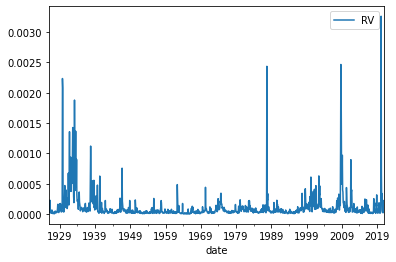

In [15]:


# We denote `realized variance` for the market return as `RV`
RV=daily[['vwretd']].groupby(endofmonth).var()
# rename column to clarify
RV=RV.rename(columns={'vwretd':'RV'})
RV.plot()

**From signal to weights**

* weight on the market:

$$w_t=c\frac{1}{rv_t}$$

* weight on the risk-free rate: $1-w_t$

* $c$ controls how levered is the strategy on average.

* As we saw before all timing strategies involved some in and out of the market, but you also need to determine the average position. That is the role of $c$.

* Lets set $c$ such that the leverage is 4 when the annualized standard deviation is 4% (which is equivalent to a daily variance of $rv=0.04^2/252$)

* leverage is $W_t-1$ (you borrow by shorting the risk-free rate)
  $$W_t-1=\frac{c}{rv_t}-1\leq 4$$

* So $c= 5 rv_t=5*0.04^2/252$

0.918452009960208

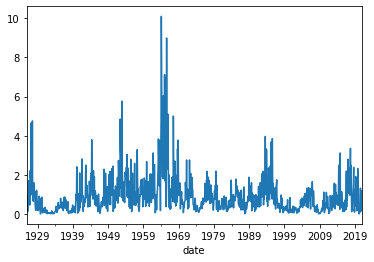

In [19]:
# calculate weights for the risky assets (market)
c=(5*(0.04**2)/252)
RV['Weight']=c/RV.RV

RV.Weight.plot()
RV.Weight.mean()

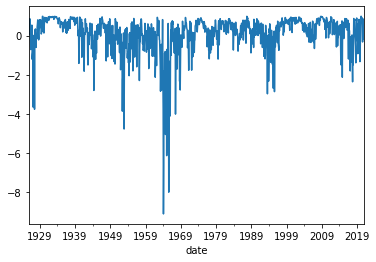

In [11]:
# plot the weights on the risk-free rate
(1-RV.Weight).plot()
plt.show()

**Aggregate daily returns to monthly**

* Since the strategy will trade monthly, we now need to construct monthly returns

* we do that by cumulating daily returns within a month


In [17]:
# aggregate daily returns to monthly returns
Ret=(1+daily).groupby(endofmonth).prod()-1
# rename columns to clarify
Ret.tail()

,vwretd,rf
date,,
2020-08-31,0.068549,0.0
2020-09-30,-0.034910,0.0
2020-10-31,-0.020180,0.0
2020-11-30,0.123639,0.0
2020-12-31,0.044672,0.0


In [20]:
# Merge Ret (monthly return) with RV (realized variance and weights)
df=RV.merge(Ret,how='left',left_index=True,right_index=True)
df.tail()

,RV,Weight,vwretd,rf
date,,,,
2020-08-31,0.000024,1.323402,0.068549,0.0
2020-09-30,0.000228,0.139017,-0.034910,0.0
2020-10-31,0.000154,0.206066,-0.020180,0.0
2020-11-30,0.000090,0.353568,0.123639,0.0
2020-12-31,0.000027,1.185148,0.044672,0.0


**Construct strategy returns**

* Now to construct the strategy return recall that we use the relaized variance in month t to buy the market at the closing of month t and earn the return accrued in month t+1

* So we need to lag our weights, or lead the returns

* I will call the strategy as $\textbf{VMS}$ (Volatility Managed Strategy)

In [21]:
# compare with the weight before . It simply shifts the weght from month t to month t+1
df.Weight.shift(1).tail()

date
2020-08-31    0.435234
2020-09-30    1.323402
2020-10-31    0.139017
2020-11-30    0.206066
2020-12-31    0.353568
Name: Weight, dtype: float64

In [26]:
# now construct the return of the strategy
df['VMS']=df.Weight.shift(1)*df.vwretd+(1-df.Weight.shift(1))*df.rf

We can see the cumulative returns of the market and the volatility managed strategy

<AxesSubplot:xlabel='date'>

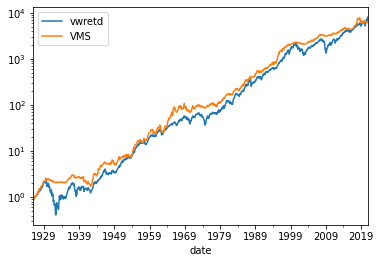

In [28]:
(df[['vwretd','VMS']]+1).cumprod().plot(logy=True)


**Volatility is more stable**



<AxesSubplot:xlabel='date'>

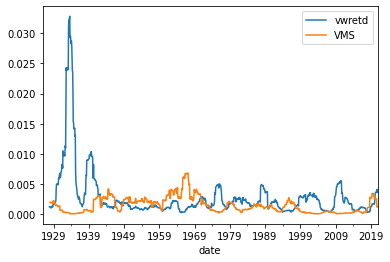

In [35]:
df[['vwretd','VMS']].rolling(window=24).var().plot()

**Average returns**

<AxesSubplot:xlabel='date'>

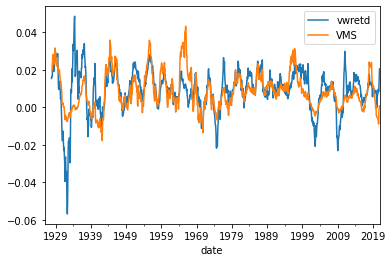

In [36]:
df[['vwretd','VMS']].rolling(window=24).mean().plot()

**Sharpe ratio**

The VMS strategy ends up with a 20% higher Sharpe Ratio

In [31]:
(df[['vwretd','VMS']].subtract(df.rf,axis=0).mean()/df[['vwretd','VMS']].std())*12**0.5

vwretd    0.431226
VMS       0.513687
dtype: float64

**Tail risk**

The VMS bears substantially less tail risk as well

We can look at the bottom 0.5% returns

In [33]:
df[['vwretd','VMS']].quantile(q=0.005)

vwretd   -0.187543
VMS      -0.133776
Name: 0.005, dtype: float64